# DACON 월간 데이콘 한국어 문장 관계 분류 경진대회
[월간 데이콘 한국어 문장 관계 분류 경진대회](https://dacon.io/competitions/official/235875/overview/description)  
[참고 노트북 | Hugging Face를 활용한 Modeling(public: 0.841)](https://dacon.io/competitions/official/235875/codeshare/4520?page=1&dtype=recent)

### EDA
데이터셋의 구조와 문장 분포 확인

In [1]:
import os
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import koreanize_matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Data Load

In [3]:
# PATH = "./dataset/"
PATH = "/content/drive/MyDrive/Classifying Korean Sentence Relationships/dataset"

train = pd.read_csv(os.path.join(PATH, "train_data.csv"), encoding="utf8")
test =  pd.read_csv(os.path.join(PATH, "test_data.csv"),  encoding="utf8")

train.shape, test.shape

((24998, 4), (1666, 4))

In [4]:
train.head()

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


#### 분포 확인

In [5]:
print(train.info(), end="\n\n")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       24998 non-null  int64 
 1   premise     24998 non-null  object
 2   hypothesis  24998 non-null  object
 3   label       24998 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


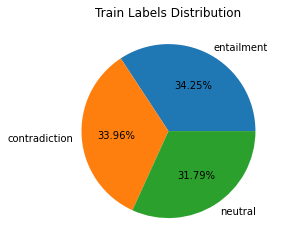

In [6]:
plt.figure(facecolor="white")
plt.title("Train Labels Distribution")
plt.pie(train["label"].value_counts().values, labels=train["label"].value_counts().index, autopct="%.2f%%");

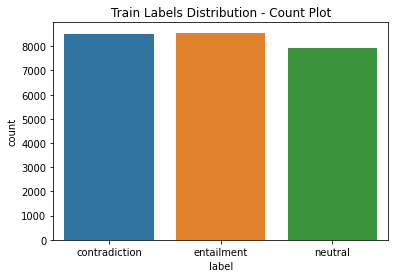

In [7]:
sns.countplot(x=train["label"]).set_title("Train Labels Distribution - Count Plot");

#### 결측치 확인

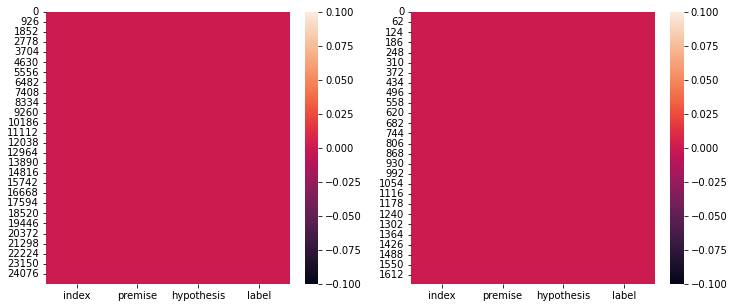

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,  5))
sns.heatmap(train.isna(), ax=ax[0])
sns.heatmap(test.isna(), ax=ax[1])
plt.show()

#### 전제, 가설 길이 확인
`train`에 존재하는 전제(Premise)와 가설(Hypothesus)의 길이를 확인하고 이를 통해 `Tokenizer`의  `max_length`  설정이 가능

In [9]:
max_len = np.max(train["premise"].str.len())
min_len = np.min(train["premise"].str.len())
mean_len = np.mean(train["premise"].str.len())
print(f"Premise -\nMax Len: {max_len}\nMean Len: {mean_len}\nMin Len: {min_len}")

max_len = np.max(train["hypothesis"].str.len())
min_len = np.min(train["hypothesis"].str.len())
mean_len = np.mean(train["hypothesis"].str.len())
print()
print(f"Hypothesis -\nMax Len: {max_len}\nMean Len: {mean_len}\nMin Len: {min_len}")

Premise -
Max Len: 90
Mean Len: 45.406552524201935
Min Len: 19

Hypothesis -
Max Len: 103
Mean Len: 24.924433954716378
Min Len: 5


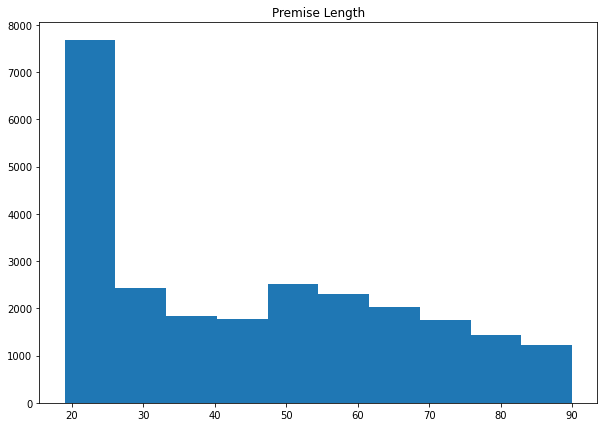

In [10]:
from collections import Counter

plt.figure(figsize=(10, 7))
plt.title("Premise Length")
plt.hist(train["premise"].str.len());

#### Test Preporcessing
전제, 가설에 존재하는 한글 단어가 아닌 다른 단어들은 전부 제거

In [11]:
train["premise"] = train["premise"].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 0-9]","", regex=True)
test["premise"] = test["premise"].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 0-9]","", regex=True)

In [12]:
train["hypothesis"] = train["hypothesis"].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 0-9]","", regex=True)
test["hypothesis"] = test["hypothesis"].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 0-9]","", regex=True)

### Modeling

In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import os
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Load Tokenizer
Hugging Face Hub에 존재하는 사전 훈련된 tokenizer와 모델 및 모델 설정 이용

In [16]:
MODEL_NAME = "klue/roberta-large"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config =  AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

In [17]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [18]:
print(config)

RobertaConfig {
  "_name_or_path": "klue/roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertTokenizer",
  "transformers_version": "4.21.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32000
}



#### Tokenizing
Train 데이터를 Train과 Validation으로 나누고 각각 데이터를 토큰화  
토큰화되는 문장ㅇ은 전제와 가설을 `concat`한 문장

In [19]:
train, valid = train_test_split(train, test_size=0.2, shuffle=True, stratify=train["label"])

train.shape, valid.shape

((19998, 4), (5000, 4))

In [20]:
tokenized_train = tokenizer(
    list(train["premise"]),
    list(train["hypothesis"]),
    return_tensors="pt",
    max_length=256,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_valid = tokenizer(
    list(valid["premise"]),
    list(valid["hypothesis"]),
    return_tensors="pt",
    max_length=256,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

In [21]:
print(tokenized_train["input_ids"][0])

tensor([    0,  3624,  2170,  4107,  2211,  6233,  7475,  2470,  1485, 11497,
         2052,  3669,  7399,  2079,  5289,  2138, 14689,  4683,  7629, 31302,
         2259,  4258,  2062,     2, 11497,  2073,  4041,  2211,  2299,  3683,
         7475,  2116,  3662,  2205,  2062,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])


In [22]:
print(tokenizer.decode(tokenized_train["input_ids"][0]))

[CLS] 때문에 22명으로 기재한 위 칼럼이 사실 왜곡의 의도를 지녔다고 판정하기는 어렵다 [SEP] 칼럼은 21명까지만 기재가 가능하다 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [23]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label
    def __getitem__(self, idx):
        item = {key:val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item["label"] = torch.tensor(self.label[idx])
        return item
    def __len__(self):
        return len(self.label)

In [24]:
def label_to_num(label):
    label_dict = {"entailment":0, "contradiction":1, "neutral":2, "answer":3}
    num_label = []
    for v in label:
        num_label.append(label_dict[v])
    return num_label

In [25]:
train_label = label_to_num(train["label"].values)
valid_label = label_to_num(valid["label"].values)

In [26]:
train_dataset = BERTDataset(tokenized_train, train_label)
valid_dataset = BERTDataset(tokenized_valid, valid_label)

print(train_dataset.__len__())
print(train_dataset.__getitem__(19997))
print(tokenizer.decode(train_dataset.__getitem__(19997)["input_ids"]))

19998
{'input_ids': tensor([    0,  4739,  6233, 15447,   570,  2408,  2069,  9381, 19521,  1545,
         2256,   570,  2408,  2069,  8585,  2073,  6099,  2470, 19777,  2348,
         2209,  8739,     2, 15447,   570,  2408,  2069,  9381, 19521,  1545,
         2256,   570,  2408,  2069, 16925,  2470,  6099,  2470, 19777,  2348,
         2209,  8739,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
def compute_metrics(pred):
    # validation을 위한 metrics func.
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = pred.predictions
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc}

In [28]:
training_ars = TrainingArguments(
    output_dir="./result",
    num_train_epochs=7,
    per_device_train_batch_size=32,
    save_total_limit=5,
    save_steps=500,
    evaluation_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True
)

trainer = Trainer(
    model = model,
    args = training_ars,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [29]:
trainer.train()
model.save_pretrained("./result/best_model")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19998
  Num Epochs = 7
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4375


Step,Training Loss,Validation Loss,Accuracy
500,1.116300,1.099470,0.339600
1000,1.109100,1.099542,0.339600
1500,1.106200,1.104970,0.339600
2000,1.104500,1.109457,0.342400
2500,1.103100,1.098380,0.339600
3000,1.102200,1.098596,0.339600
3500,1.101200,1.098708,0.342400
4000,1.101300,1.098195,0.342400


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to ./result/checkpoint-500
Configuration saved in ./result/checkpoint-500/config.json
Model weights saved in ./result/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./result/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./result/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to ./result/checkpoint-1000
Configuration saved in ./result/checkpoint-1000/config.json
Model weights saved in ./result/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./result/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./result/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to ./result/checkpoint-1500
Configuration saved in ./result/checkpoint-1500/config.json
Model weights s

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = './result/checkpoint-4000'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

print(tokenizer)

loading file https://huggingface.co/klue/roberta-large/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/4eb906e7d0da2b04e56c7cc31ba068d7c295240a51690153c2ced71c9e4c9fc5.d1b86bed49516351c7bb29b19d7e7be2ab53b931bcb1f9b2aacfb71f2124d25a
loading file https://huggingface.co/klue/roberta-large/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/360b579947002f14f22331a026821b56f70679f1be1e95fe5dc5a80edc4a59e0.44c30ade4958fcfd446e66025e10a5b380cdd0bbe9b3fb7a794f357e7f0f34c2
loading file https://huggingface.co/klue/roberta-large/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/klue/roberta-large/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/1a24ab4628028ed80dea35ce3334a636dc656fd9a17a09bad377f88f0cbecdac.70c17d6e4d492c8f24f5bb97ab56c7f272e947112c6faf9dd846da42ba13eb23
loading file https://huggingface.co/klue/roberta-large/resolve/main/tokenizer_config.json from c

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [31]:
test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

print(test_dataset.__len__())
print(test_dataset.__getitem__(1665))
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))

1666
{'input_ids': tensor([    0,   720,  3994,  2052, 10428,  2775,   647,  3657,  2119,  1085,
            3,     2,   720,  3994,  2052,   911,  2075,  3669,  2119,  3926,
         2088,  1513,  2359, 13964,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [32]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

100%|██████████| 105/105 [00:21<00:00,  4.80it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [33]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(pred_answer)
print(answer)

[[0, 'entailment'], [1, 'entailment'], [2, 'entailment'], [3, 'entailment'], [4, 'entailment'], [5, 'entailment'], [6, 'entailment'], [7, 'entailment'], [8, 'entailment'], [9, 'entailment'], [10, 'entailment'], [11, 'entailment'], [12, 'entailment'], [13, 'entailment'], [14, 'entailment'], [15, 'entailment'], [16, 'entailment'], [17, 'entailment'], [18, 'entailment'], [19, 'entailment'], [20, 'entailment'], [21, 'entailment'], [22, 'entailment'], [23, 'entailment'], [24, 'entailment'], [25, 'entailment'], [26, 'entailment'], [27, 'entailment'], [28, 'entailment'], [29, 'entailment'], [30, 'entailment'], [31, 'entailment'], [32, 'entailment'], [33, 'entailment'], [34, 'entailment'], [35, 'entailment'], [36, 'entailment'], [37, 'entailment'], [38, 'entailment'], [39, 'entailment'], [40, 'entailment'], [41, 'entailment'], [42, 'entailment'], [43, 'entailment'], [44, 'entailment'], [45, 'entailment'], [46, 'entailment'], [47, 'entailment'], [48, 'entailment'], [49, 'entailment'], [50, 'ent

In [34]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('./result/submission.csv', index=False)

print(df)

      index       label
0         0  entailment
1         1  entailment
2         2  entailment
3         3  entailment
4         4  entailment
...     ...         ...
1661   1661  entailment
1662   1662  entailment
1663   1663  entailment
1664   1664  entailment
1665   1665  entailment

[1666 rows x 2 columns]
